# OpenVDS+ File Access
OpenVDS+ is a Bluware product to store seismic data natively in the cloud.
Details can be found [here](https://bluware.com/data-solutions/vds/#openvds).

Seismic data written on SEG-Y standard data is sequential. This causes performance complications when
random or orthogonal (crossline) access patterns are introduced.

VDS format is a much more sophisticated binary file format that addresses these issues by:

1. Adaptive Data Compression - *Reduces bandwidth and storage requirements*
2. Bricked Format - *Speeds up random access*
3. Cloud Native and Local - *Cloud objects and individual files*
4. Level of Detail (LOD) - *Improves streaming*

OpenVDS is a part of the OSDU (Open Subsurface Data Universe).

OpenVDS+ is a public but closed-source version of OpenVDS that includes *Wavelet Compression*.

This notebook demonstrates how we can access and query VDS files from AWS S3 buckets.

To install OpenVDS+ please download Python wheels from [here](https://bluware.com/data-solutions/vds/#openvds+).
Then it can be installed from a terminal via

python -m pip install openvds-version.whl`

Lets assume we installed it and start with some imports:

In [1]:
from os import getenv  # To get credentials
from time import time  # To time downloads
import numpy as np  # Helps with plots
import matplotlib.pyplot as plt  # Plots
import openvds  # Python bindings for OpenVDS+ library

# Below are convenience functions we wrote to query the data and metadata.
from vds_utils import (
    get_minicube,
    get_slice,
    print_channel_info,
    print_crs_metadata,
)

ModuleNotFoundError: No module named 'openvds'

# Loading AWS Credentials
<span style="color:red">**THIS ONLY APPLIES TO ON-PREM (LOCAL) ACCESS TO S3 DATA. IF YOU ARE ON SAGEMAKER DON'T DO THIS.**

AWS credentials must be stored in environment variables.

To access competition data on-premise, you will need these environment variables set. They expire occasionally, so please update your variables when you get permission errors. See instructions PDF on how to obtain them.

Variables: `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, and `AWS_SESSION_TOKEN`

If these are not set, you will get a "Forbidden" error. Configuring this depends on your operating system. It needs to be set in your global environment or within your virtual environment **before** launching Jupyter server or scripts. It is usually set using terminal. AWS SSO logins provides a convenient way to copy these for your account into your terminal or command-prompt. It will look something like this:


| **Linux / UNIX / MacOS**                                | **Windows**                                        |
|:--------------------------------------------------------|---------------------------------------------------:|
| `export AWS_ACCESS_KEY_ID="your_access_key"`            | `SET AWS_ACCESS_KEY_ID=your_access_key`            |
| `export AWS_SECRET_ACCESS_KEY="your_secret_access_key"` | `SET AWS_SECRET_ACCESS_KEY=your_secret_access_key` |
| `export AWS_SESSION_TOKEN="your_long_session_token"`    | `SET AWS_SESSION_TOKEN=your_long_session_token`    |

After credentials are set, we can read data from the S3 buckets just like we are on SageMaker environment.

# Connecting to the VDS File

Below are S3 bucket paths for Poseidon seismic data. We start by using the full stack.

We open the VDS file using `openvds.open` and retreive the `layout`. This explains the geometry
of the seismic data.

Seismic geometry is information about trace coordinates, and inline/xline positions.

After we receive the layout, we print some information about it!

In [3]:
# vds_url = r's3://sagemaker-gitc2021/poseidon/seismic/vds/psdn11_TbsdmF_Near_Nov_11_32bit/'
# vds_url = r's3://sagemaker-gitc2021/poseidon/seismic/vds/psdn11_TbsdmF_Mid_Nov_11_32bit/'
# vds_url = r's3://sagemaker-gitc2021/poseidon/seismic/vds/psdn11_TbsdmF_Far_Nov_11_32bit/'
vds_url = r's3://sagemaker-gitc2021/poseidon/seismic/vds/psdn11_TbsdmF_full_w_AGC_Nov11/'

region = 'us-east-1'
region_config = f"Region={region}"

aws_config = ';'.join([
    region_config,
])

vds_handle = openvds.open(
    url=vds_url,
    connectionString=aws_config,
)

layout = openvds.getLayout(vds_handle)

print_channel_info(layout)
print_crs_metadata(layout)

ChannelCount: 3
  Channel Name: Amplitude
    Value range: -15334.1142578125 - 15334.1142578125
  Channel Name: Trace
    Value range: 0.0 - 256.0
  Channel Name: SEGYTraceHeader
    Value range: 0.0 - 256.0
Dimensionality: 3
  Dimension name: Sample
    Number of samples: 1501
    Coordinate min max 0.0 - 6000.0
  Dimension name: Crossline
    Number of samples: 5053
    Coordinate min max 504.0 - 5556.0
  Dimension name: Inline
    Number of samples: 3437
    Coordinate min max 983.0 - 4419.0
SurveyCoordinateSystem::Origin: (409110.54968723457, 8429425.04864461)
SurveyCoordinateSystem::InlineSpacing: (12.052651580247169, 14.363472429446059)
SurveyCoordinateSystem::CrosslineSpacing: (-9.57557031868567, 8.035035629453683)


We observe the VDS data has 3 channels that hold seismic amplitudes, and some headers (metadata).

It is a three-dimensional array where the first dimension is sample coordinates (two-way-time in this case),
crossline dimension, and finally inline dimension.

The last prints show the physical coordinates of the survey origin, and line spacings.

Now we need to define a `VolumeDataAccessManager`, which is used to access the VDS file.
The convenience functions we provide make use of the access manager, and the layout to retreive
lines, or minicubes of interest.

In [4]:
access_manager = openvds.VolumeDataAccessManager(vds_handle)

Below cell retrieves a range of inlines, crosslines, and two-way-time values.

In [5]:
t0 = time()

il_range = (2550, 2650)
xl_range = (2950, 3050)
z_range = (2000, 4000)

mini_cube = get_minicube(
    access_manager=access_manager,
    layout=layout,
    il_range=il_range,
    xl_range=xl_range,
    z_range=z_range,
)

print(f"Retreived minicube in {time() - t0:.2f} seconds.")
print("Shape of minicube", mini_cube.shape)

Retreived minicube in 1.63 seconds.
Shape of minicube (101, 101, 501)


Here, we observe we retreived a minicube with 101 inlines, 101 crosslines, and 501 samples.

***From. The. Cloud.***

***Very. Fast.***

Now, let's display this minicube with some `matplotlib` magic.

VDS also caches previously used data. Let's try loading a subset of the previous slice again, and compare times.

We drop only 1 inline/xline from each edge.

In [6]:
t0 = time()

il_range = (2551, 2649)
xl_range = (2951, 3049)
z_range = (2000, 4000)

mini_cube = get_minicube(
    access_manager=access_manager,
    layout=layout,
    il_range=il_range,
    xl_range=xl_range,
    z_range=z_range,
)

print(f"Retreived minicube in {time() - t0:.2f} seconds.")
print("Shape of minicube", mini_cube.shape)

Retreived minicube in 0.01 seconds.
Shape of minicube (99, 99, 501)


Now that is much faster! Because we are using local files instead of downloading from the cloud.

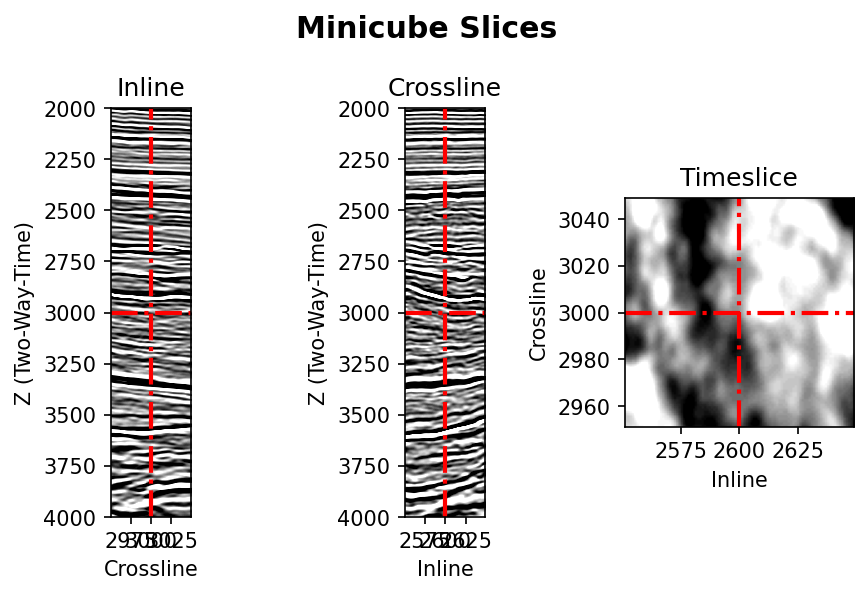

In [7]:
fig, (ax_il, ax_xl, ax_z) = plt.subplots(1, 3, dpi=150)

image_kwargs = {
    'vmin': -5250,
    'vmax': 5250,
    'cmap': 'gray',
}

line_kwargs = {
    'color': 'red',
    'linewidth': 2,
    'linestyle': '-.',
}

n_il, n_xl, n_z = mini_cube.shape
ax_il.imshow(mini_cube[n_il // 2, :, :].T, extent=[*xl_range, *z_range[::-1]], aspect=0.25, **image_kwargs)
ax_il.axvline(np.mean(xl_range), **line_kwargs)
ax_il.axhline(np.mean(z_range), **line_kwargs)
ax_il.set_xlabel('Crossline')
ax_il.set_ylabel('Z (Two-Way-Time)')
ax_il.set_title('Inline')

ax_xl.imshow(mini_cube[:, n_xl // 2, :].T, extent=[*il_range, *z_range[::-1]], aspect=0.25, **image_kwargs)
ax_xl.axvline(np.mean(il_range), **line_kwargs)
ax_xl.axhline(np.mean(z_range), **line_kwargs)
ax_xl.set_xlabel('Inline')
ax_xl.set_ylabel('Z (Two-Way-Time)')
ax_xl.set_title('Crossline')

ax_z.imshow(mini_cube[:, :, n_z // 2].T, extent=[*il_range, *xl_range], aspect=1, origin='lower', **image_kwargs)
ax_z.axhline(np.mean(xl_range), **line_kwargs)
ax_z.axvline(np.mean(il_range), **line_kwargs)
ax_z.set_xlabel('Inline')
ax_z.set_ylabel('Crossline')
ax_z.set_title('Timeslice')

fig.suptitle("Minicube Slices", size='x-large', weight='bold')
fig.tight_layout()

Everything working great. This could be a minicube that spans our well!

Next cell demos inline, crossline, and timeslice capabilities.

In [8]:
t0 = time()

il_slice = get_slice(
    access_manager=access_manager,
    layout=layout,
    slice_type='inline',
    slice_coordinate=2600
)

xl_slice = get_slice(
    access_manager=access_manager,
    layout=layout,
    slice_type='crossline',
    slice_coordinate=3000
)

twt_slice = get_slice(
    access_manager=access_manager,
    layout=layout,
    slice_type='timeslice',
    slice_coordinate=3000
)

print(f"Downloaded three orthogonal slices in {time() - t0:.3f} seconds.")

Downloaded three orthogonal slices in 1.925 seconds.


Finally we can plot the inline, crossline, and timeslices.

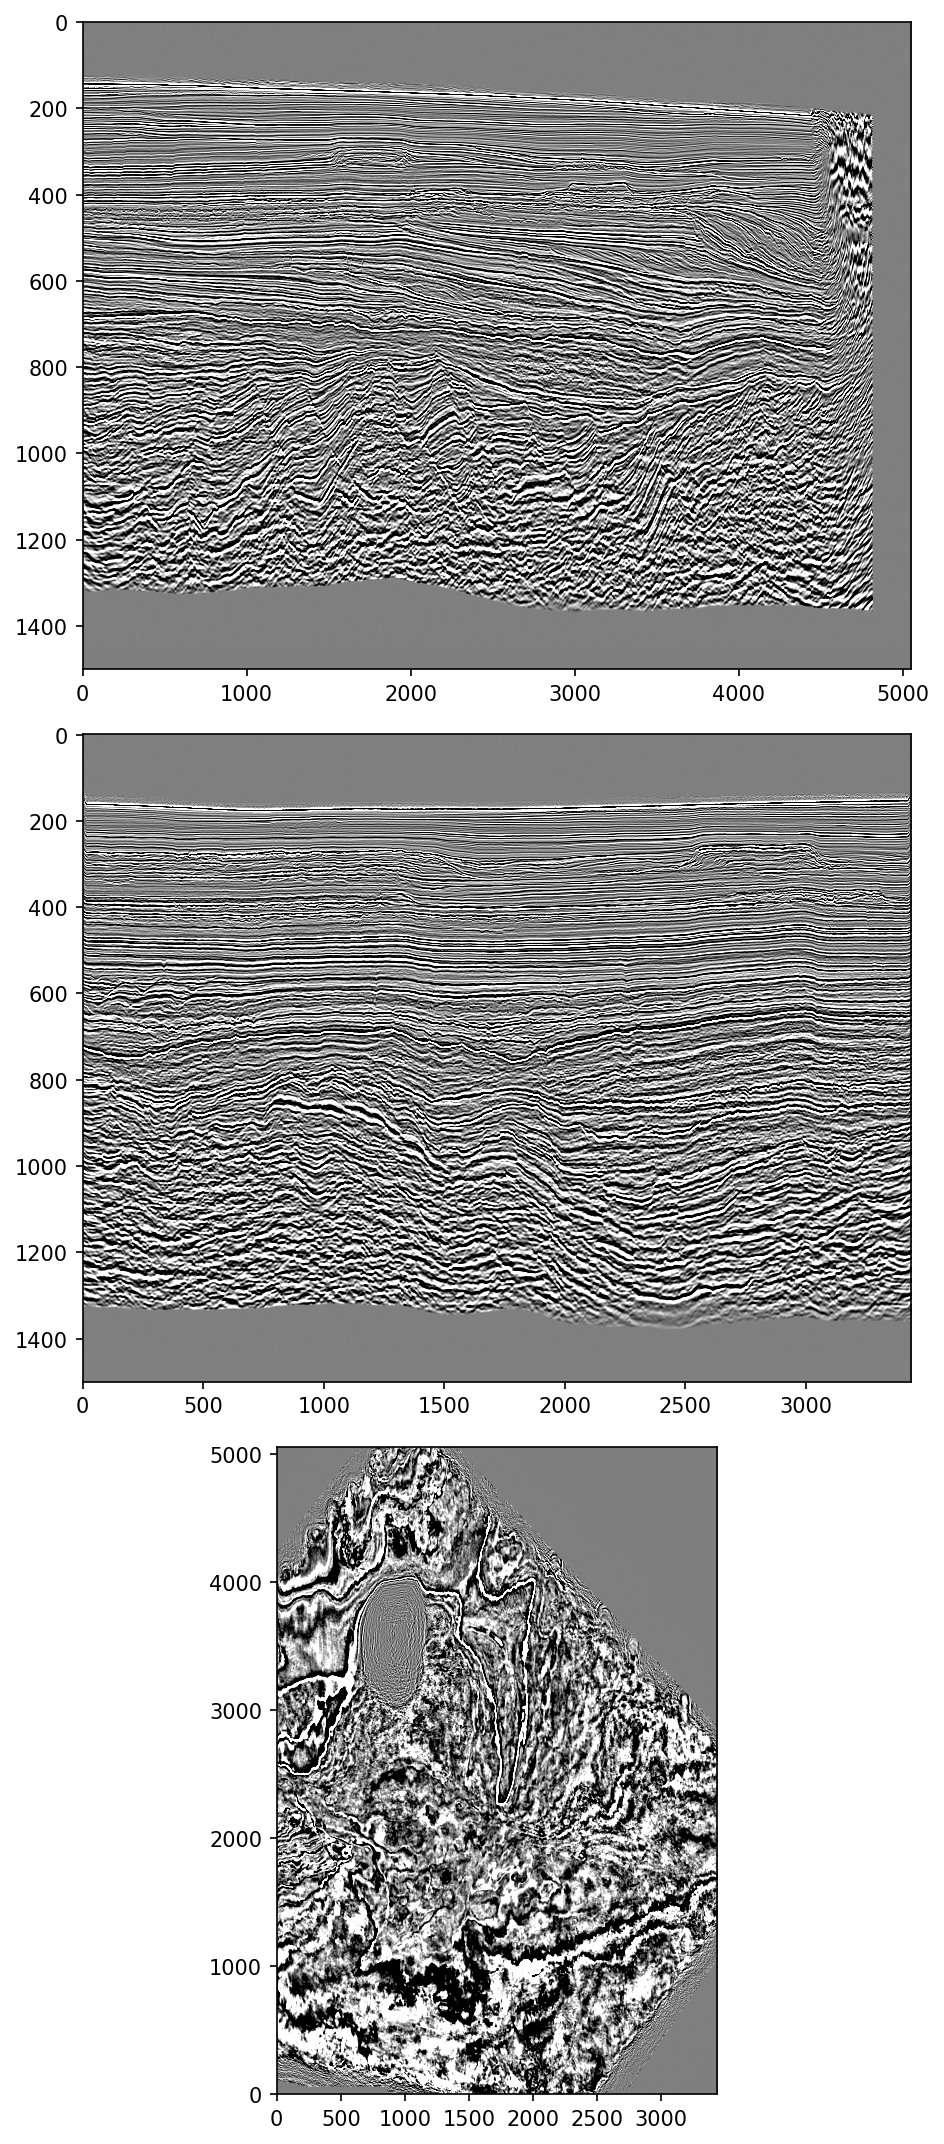

In [9]:
cmap = "gray"
fig, (ax_il, ax_xl, ax_z) = plt.subplots(3, 1, dpi=150, figsize=[6.4, 14.4])
ax_il.imshow(il_slice.T, aspect='auto', **image_kwargs)
ax_xl.imshow(xl_slice.T, aspect='auto', **image_kwargs)
ax_z.imshow(twt_slice.T, aspect=1, origin='lower', **image_kwargs)

fig.tight_layout()

Once we are done with the VDS file, it is good practice to close it.
This may potentially work with a context manager.

In [10]:
openvds.close(vds_handle)